### Automation of Ms. PAC-MAN using Reinforcement Learning
##### Contents

- [Step 1: Import necessary libraries](#Step-1-Import-necessary-libraries)
- [Step 2: Creating the Ms. Pacman environment](#Step-2-Creating-the-Ms.-Pacman-environment)
- [Step 3: Preprocessing](#Step-3-Preprocessing)
- [Step 4: Deep Q-Network Model](#Step-4-Deep-Q--Network-Model)
- [Step 5: Define Training Operations](#Step-5-Define-Training-Operations)
- [Step 6: Replay Memory](#Step-6-Replay-Memory)
- [Step 7: Exploration Strategy](#Step-7-Exploration-Strategy)
- [Step 8: Training Configuration](#Step-8-Training-Configuration)
- [Step 9: Tracking Progress](#Step-9-Tracking-Progress)
- [Step 10: Main Training Loop](#Step-10-Main-Training-Loop)
- [Step 11: Test the Trained Agent](#Step-11-Test-the-Trained-Agent)
- [Step 12: visualize the gameplay](#Step-12-visualize-the-gameplay)
- [Step 13: Close the environment](#Step-13-Close-the-environment)

#### Step 1: Import necessary libraries

In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import matplotlib.animation as animation
%matplotlib inline

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


#### Step 2: Creating the MsPacman environment

In [2]:
# Create Ms. Pac-Man environment
env = gym.make("MsPacman-v0", render_mode="rgb_array")
obs = env.reset()[0]

# Display Initial Observation Information
print("Initial Observation Shape:", obs.shape)
print("Action Space:", env.action_space)

Initial Observation Shape: (210, 160, 3)
Action Space: Discrete(9)


#### Step 3: Preprocessing

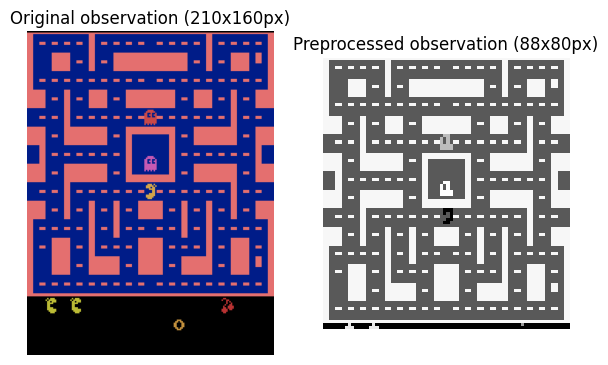

In [3]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    """
    Preprocesses the raw observation from the environment.

    This function performs the following steps:
    1. Crop and downsize the image.
    2. Convert the image to greyscale.
    3. Improve contrast by setting specific pixel values to 0.
    4. Normalize pixel intensities from -128 to 127.

    Parameters:
    - obs (numpy.ndarray): Raw observation from the environment.

    Returns:
    - numpy.ndarray: Preprocessed image with shape (88, 80, 1).
    """
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

# Display original and preprocessed observations
img = preprocess_observation(obs)
plt.figure(figsize=(7, 5))
plt.subplot(121)
plt.title("Original observation (210x160px)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88x80px)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

#### Step 4: Deep Q-Network Model

In [4]:
# Define Deep Q-Network parameters
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.compat.v1.variance_scaling_initializer()

def q_network(X_state, name):
    """
    Defines a Deep Q-Network (DQN) for reinforcement learning.

    Parameters:
    - X_state (tf.Tensor): Input state placeholder.
    - name (str): Name of the network.

    Returns:
    - tuple: (tf.Tensor, dict) - Output tensor with Q-values, and trainable variables.

    The DQN architecture includes convolutional and fully connected layers.
    """
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.compat.v1.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.compat.v1.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.compat.v1.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.compat.v1.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

# Placeholder for input state
X_state = tf.compat.v1.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels]) 

# Define operations to copy online DQN to target DQN
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

# Define operations to copy online DQN to target DQN
copy_ops = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

#### Step 5: Define Training Operations

In [5]:
# Define training hyperparameters
learning_rate = 0.0001  
momentum = 0.95  

with tf.compat.v1.variable_scope("train"):
    X_action = tf.compat.v1.placeholder(tf.int32, shape=[None])
    y = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

#### Step 6: Replay Memory

In [6]:
class ReplayMemory:
    """
    Simple replay memory for storing and sampling experiences.

    Parameters:
    - maxlen (int): Maximum capacity of the replay memory.

    Methods:
    - __init__(maxlen): Initializes the replay memory.
    - append(data): Adds a new experience to the memory.
    - sample(batch_size, with_replacement=True): Samples a batch of experiences.
    """
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0

    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen

    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]
    
# Create an instance of ReplayMemory
replay_memory_size = 1000000  
replay_memory = ReplayMemory(replay_memory_size)

def sample_memories(batch_size):
    """
    Sample memories from the replay memory.
    
    Parameters:
    - batch_size (int): Number of samples to retrieve.
    
    Returns:
    - Tuple of arrays: Sampled states, actions, rewards, next_states, and continues.
    """
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

#### Step 7: Exploration Strategy

In [7]:
# Define exploration strategy parameters
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

# Define epsilon-greedy exploration strategy
def epsilon_greedy(q_values, step):
    """
    Epsilon-greedy exploration strategy.
    
    Parameters:
    - q_values (array): Q-values for each action.
    - step (int): Current training step.
    
    Returns:
    - int: Selected action.
    """
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

#### Step 8: Training Configuration


In [8]:
n_steps = 6000  # total number of training steps (very small)
training_start = 100  # start training after 100 game iterations (very small)
training_interval = 1  # run a training step every game iteration (training every step for demonstration purposes)
save_steps = 10  # save the model every 10 training steps (very small)
copy_steps = 100  # copy online DQN to target DQN every 100 training steps (very small)
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 64
iteration = 0  # game iterations
checkpoint_path = "./modelweights.ckpt" 
done = True # env needs to be reset
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0


#### Step 9: Tracking Progress

In [9]:
# Initialize variables for tracking progress
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

#### Step 10: Main Training Loop

In [10]:
with tf.compat.v1.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done,truncated, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done,truncated, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals

        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 6099	Training step 5999/6000 (100.0)%	Loss 0.298194	Mean Max-Q 4.098692   

#### Step 11: Test the Trained Agent

In [19]:
# Test the trained agent
frames = []
n_max_steps = 100000
reward_score = 0

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()[0]
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done,truncated, info = env.step(action)
        reward_score += reward
        
        img = env.render()
        frames.append(img)

        if done:
            break

print("reward_score:", reward_score)

INFO:tensorflow:Restoring parameters from ./modelweights.ckpt


INFO:tensorflow:Restoring parameters from ./modelweights.ckpt


reward_score: 990


#### Step 12: visualize the gameplay


In [12]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Display animation
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('animation', html='html5')
plot_animation(frames)


#### Step 13: Close the environment

In [13]:
# Close the environment
env.close()